In [1]:
import torch
import yaml
import einops
import torchvision
import os
from tqdm import tqdm
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms.functional import to_pil_image
import torch.nn.functional as F
import umap.umap_ as umap
from utils import make_coord_grid
import yaml
from datasets import make as make_dataset
from models import make as make_model
import pickle
from sklearn.manifold import TSNE
import os
from glob import glob
import ipywidgets as widgets
from ipywidgets import interact_manual
import matplotlib.pyplot as plt
import numpy as np
import monai.transforms as monai_t
from datasets.fmri_dataloader import DataModule

def load_config(yaml_path):
    with open(yaml_path, 'r') as f:
        return yaml.safe_load(f)

def resize_sequence(seq, resize):
        B, C, H, W, D, T = seq.shape
        spatial_size = [resize,  resize, resize]
        resized_shape = [B, C] + spatial_size + [T]
        resize_transform = monai_t.Resize(spatial_size=(spatial_size))
        seq = einops.rearrange(seq, 'b c h w d t -> b t c h w d')
        seq_resized = torch.zeros(resized_shape).to(seq.device)
        for b in range(B):
            for t in range(T):
                seq_resized[b, :, :, :, :, t] = resize_transform(seq[b, t, :, :, :, :])
        del seq
        print(seq_resized.shape)
        return seq_resized
    
@torch.no_grad()
def evaluate_model(model, dataloader, device='cuda', res_factor = 1, lainr = True, only_one=False, sr = True):
    model.eval()
    total_loss = 0
    total_psnr = 0
    count = 0
    i = 0

    for data in tqdm(dataloader, desc='Evaluating'):
        if i > 0 and only_one:
            break

        data = {k: (v.cuda() if isinstance(v, torch.Tensor) else v) for k, v in data.items()}

        '''for k, v in data.items():
            if torch.is_tensor(v):
                data[k] = v.cuda()'''
        #gt = data.pop('gt')
        gt_full = data.pop('fmri_sequence')
        resize = 48
        gt_full = resize_sequence(gt_full, resize)
        #print(f'gt_full shape is {gt_full.shape}')
        
        B = gt_full.shape[0]
        coord = make_coord_grid(gt_full.shape[-4:], (0, 1), device=gt_full.device)
        #print(coord.shape)
        coord = einops.repeat(coord, 'z h w t d -> b z h w t d', b=B)
        coord = coord[:, :, :, 24:25, 0:1, :] #(1, 1, H, W, 1, C)
        coord_flat = coord.view(B, -1, coord.shape[-1])  # (B, N, dim), N=Z*H*W*T
        #print(gt_full.shape)

        B, C, D, H, W, T = gt_full.shape
       
        pred = model(gt_full, coord_flat)
        gt_full = einops.rearrange(gt_full, 'b c z h w t -> b z h w t c')
        pred = pred.view(B, D, H, 1, 1, C)
        pred2 = pred.squeeze(3)
        pred2 = pred2.squeeze(3)[0]
        pred2 = einops.rearrange(pred2, 'h w c -> c h w')  

        #print(pred2.shape)
        #print(pred2[:, 0:15, 0:15])

        #print("pred", pred.shape, "gt slice", gt_full[0:1, 48:49, :, :, 0:1, :].shape)
        mses = ((pred - gt_full[: , :, :, 24:25, 0:1, :])**2).view(1, -1).mean(dim=-1)
        loss = mses.mean()
        psnr = (-10 * torch.log10(mses)).mean()

        total_loss += loss.item() * B
        total_psnr += psnr.item() * B
        count += B
        i+=1

    avg_loss = total_loss / count
    avg_psnr = total_psnr / count
    print(f"Avg Loss: {avg_loss:.6f}, Avg PSNR: {avg_psnr:.2f}")
    return avg_loss, avg_psnr


@torch.no_grad()
def visualize_results(model, dataloader, device='cuda', n_samples=8, out_dir='./eval_vis', figsize=(6, 3), res_factor = 1, lainr=True, sr = True):
    os.makedirs(out_dir, exist_ok=True)
    model.eval()
    data_iter = iter(dataloader)

    for i in range(n_samples):
        try:
            data = next(data_iter)
        except StopIteration:
            break

        data = {k: (v.cuda() if isinstance(v, torch.Tensor) else v) for k, v in data.items()}

        '''for k, v in data.items():
            if torch.is_tensor(v):
                data[k] = v.cuda()'''
        #gt = data.pop('gt')
        gt_full = data.pop('fmri_sequence')
        resize = 48
        gt_full = resize_sequence(gt_full, resize)
        B = gt_full.shape[0]
        coord = make_coord_grid(gt_full.shape[-4:], (0, 1), device=gt_full.device)
        coord = einops.repeat(coord, 'z h w t d -> b z h w t d', b=B)
        coord_full = coord.view(B, -1, coord.shape[-1])
        coord = coord[:, 30:31, :, :, 0:1, :] #(1, 1, H, W, 1, C)
        coord_flat = coord.view(B, -1, coord.shape[-1])  # (B, N, dim), N=Z*H*W*T
        print(gt_full.shape)

        B, C, D, H, W, T = gt_full.shape
       
        pred = model(gt_full, coord_flat)
        #pred3 = model(gt_full, coord_full)
        #pred3 = pred3.view(B, D, H, W, T, C)
        
        gt_full = einops.rearrange(gt_full, 'b c z h w t -> b z h w t c')
        pred = pred.view(B, 1, H, W, 1, C)
        pred2 = pred.squeeze(1)
        pred2 = pred2.squeeze(3)[0]
        pred = einops.rearrange(pred2, 'h w c -> c h w')
        pred = torch.clamp(pred, 0.0, 1.0)
        print(pred.max())
        print(pred.min())

        #pred = einops.rearrange(pred, 'h w c -> c h w')  # (C, H, W)

        # Convert tensors to NumPy for plotting
        gt = gt_full[:, 30:31, :, :, 0:1, :]
        gt = gt.squeeze(1)
        gt = gt.squeeze(3)[0]
        gt = einops.rearrange(gt, 'h w c -> c h w')
        print(gt.max())
        print(gt.min())

        mses = ((pred - gt)**2).view(1, -1).mean(dim=-1)
        loss = mses.mean()
        psnr = (-10 * torch.log10(mses)).mean()
        print(psnr)
        # clamp values to [0, 1] range
        
        gt_np = gt.cpu().numpy()
        pred_np = pred.cpu().numpy()
        
        # If your images are single-channel, squeeze channel dim
        if gt_np.shape[0] == 1:
            gt_np = gt_np.squeeze(0)
            pred_np = pred_np.squeeze(0)
        
        vmin, vmax = 0.0, 1.0  # fixed scale for both
        
        fig, axes = plt.subplots(1, 2, figsize=(8, 4))
        
        # Plot images
        im0 = axes[0].imshow(gt_np, vmin=vmin, vmax=vmax, cmap='viridis')
        axes[0].set_title('Ground Truth')
        axes[0].axis('off')
        
        im1 = axes[1].imshow(pred_np, vmin=vmin, vmax=vmax, cmap='viridis')
        axes[1].set_title('Prediction')
        axes[1].axis('off')
        
        # Create one colorbar to the far right
        cbar = fig.colorbar(im0, ax=axes, shrink=0.8, pad=0.05)
        cbar.ax.tick_params(labelsize=8)
        
        #plt.tight_layout()
        plt.show()
        #return pred3
        # plt.savefig(f"{out_dir}/comparison_{i}.png")
        # plt.close(fig)

        #plt.savefig(f"{out_dir}/comparison_{i}.png")
        #plt.close(fig)

    
@torch.no_grad()
def get_volume(model, dataloader, device='cuda', n_samples=8, out_dir='./eval_vis', figsize=(6, 3), res_factor = 1, lainr=True, sr = True):
    os.makedirs(out_dir, exist_ok=True)
    model.eval()
    data_iter = iter(dataloader)

    for i in range(n_samples):
        try:
            data = next(data_iter)
        except StopIteration:
            break

        data = {k: (v.cuda() if isinstance(v, torch.Tensor) else v) for k, v in data.items()}     
        gt_full = data.pop('fmri_sequence')
        resize = 48
        gt_full = resize_sequence(gt_full, resize)
        B = gt_full.shape[0]
        coord = make_coord_grid(gt_full.shape[-4:], (0, 1), device=gt_full.device)
        coord = einops.repeat(coord, 'z h w t d -> b z h w t d', b=B)
        coord_full = coord.view(B, -1, coord.shape[-1])
        print(gt_full.shape)

        B, C, D, H, W, T = gt_full.shape
        pred3 = model(gt_full, coord_full)
        pred3 = pred3.view(B, D, H, W, T, C)
        
        gt_full = einops.rearrange(gt_full, 'b c z h w t -> b z h w t c')
        return pred3

def set_lp_idxs(seq_len, num_lp, type = 'equidistant', n = 1):
        total_len = seq_len + num_lp
        if type == 'equidistant':
            insert_idxs = torch.linspace(0, total_len - 1, steps=num_lp).long()
        elif type == 'middle':
            insert_idxs = (np.array(range(num_lp))+(seq_len//2)).tolist()
            insert_idxs = torch.tensor(insert_idxs)
        elif type == 'n_group':
            if num_lp%n != 0:
                raise Exception("n must divide number of lps evenly")
            insert_idxs = []
            pre_idxs = torch.linspace(0, total_len - n, steps=num_lp//n).long()
            for idx in pre_idxs:
                insert_idxs.extend([idx+i for i in range(n)])
        return insert_idxs


In [2]:
data_module = DataModule('./cfgs/hcp_data_all_config.yaml')
data_module.setup()
train_loader = data_module.train_dataloader()
test_loader = data_module.val_dataloader()

Loading cached subject dictionary from data/subj_dict/S1200_age_HCP_filtered_run1_MNI_to_TRs.pickle
Loading splits from ./data/splits/S1200_split2.pkl
Randomly sampling 400 of 863 subjects.
Generating dataset list from scratch...
Number of subjects for S1200 'train': 400
Randomly sampling 50 of 107 subjects.
Loading cached dataset list from data/data_tuple/age_HCP_filtered_run1_MNI_to_TRs_val_seqlen2_within1_between1.0.csv
Cache is stale (subject mismatch). Regenerating...
Generating dataset list from scratch...
Number of subjects for S1200 'val': 50
Randomly sampling 50 of 109 subjects.
Loading cached dataset list from data/data_tuple/age_HCP_filtered_run1_MNI_to_TRs_test_seqlen2_within1_between1.0.csv
Cache is stale (subject mismatch). Regenerating...
Generating dataset list from scratch...
Number of subjects for S1200 'test': 50

Total training segments: 4800
Total validation segments: 600
Total test segments: 600


In [3]:
# Load YAML config
#cfg_string = 'imgrec_cifar10_mamba_lainr_fourier_long_constant'
#cfg_string = 'imgrec_celeba_transinr'
cfg_string = 'fmri_hcp_small_patch_resizelr_min20_hfmv_resume'
#cfg_dataset_string = 'imgrec_cifar10_mamba_lainr_fourier_sr2'
cfg = load_config(f'./cfgs/{cfg_string}.yaml')
#cfg_dataset = load_config(f'./cfgs/poster_graphs/sr_comparison/{cfg_dataset_string}.yaml')
print(cfg)
#cfg['test_dataset'] = cfg_dataset['test_dataset']
#cfg_dt = cfg
#cfg_dt['model']['name'] = cfg['model']['name']+'_print_dt'
#cfg_dt['model']['args']['mamba_encoder']['name']= 'mamba_encoder_dt'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

{'trainer': 'fmri_trainer_lainr_ddp_resize_lr', 'data_module': {'name': 'fmri_datamodule', 'args': {'config_path': '/pscratch/sd/t/tbalasoo/MAMBAINR/trans-inr-master/cfgs/hcp_data_all_config.yaml'}}, 'model': {'name': 'mamba_lainr_inr_ddp_4d', 'args': {'input_size': [48, 48, 48, 2], 'patch_size': [2, 2, 2, 2], 'hyponet': {'name': 'lainr_mlp_bias_fmri', 'args': {'feature_dim': 512, 'input_dim': 4, 'output_dim': 1, 'sigma_q': 128, 'sigma_ls': [128, 32], 'n_patches': 1728}}, 'mamba_encoder': {'name': 'mamba_encoder', 'args': {'dim': 512, 'depth': 6, 'ff_dim': 2048}}, 'type': 'equidistant', 'n_group': 1, 'num_lp': 1536}}, 'optimizer': {'name': 'adamw', 'args': {'lr': 0.00015}}, 'max_epoch': 400, 'resize': 48, 'min_lr_p': 0.2, 'eval_epoch': 1, 'vis_epoch': 1, 'resume_from': 'save/fmri_hcp_small_patch_resizelr_min20_hfmv/epoch-last.pth', 'use_torch_compile': False, 'use_amp': True, 'use_augmentation': False}


In [4]:
#cfg['model']['args']['tokenizer']['name']= 'mamba_patch_tokenizer'
#cfg_dt['model']['args']['tokenizer']['name']= 'mamba_patch_tokenizer'
model = make_model(cfg['model']).to(device)
#model_dt = make_model(cfg_dt['model']).to(device)

torch.Size([1, 24, 24, 24, 1, 512])


In [5]:
# Load checkpoint
#cfg_string_train = 'imgrec_cifar10_mamba_composers_fourier_long'
cfg_string_train = cfg_string
#cfg_string_train_full = f'{cfg_string_train}'
#cfg_train = load_config(f'./cfgs/sr_ablation/{cfg_string_train_full}.yaml')
ckpt_path = f'./save/{cfg_string_train}/epoch-last.pth'
checkpoint = torch.load(ckpt_path, weights_only=False)
print(checkpoint['model'].keys())
#model = torch.load(ckpt_path)['model']
model.load_state_dict(checkpoint['model']['sd'])
#model_dt.load_state_dict(checkpoint['model']['sd'])

dict_keys(['name', 'args', 'sd'])


<All keys matched successfully>

In [ ]:
get_volume(model, train_loader, device, n_samples=10, out_dir='./eval_vis', figsize=(12, 6), res_factor = 1, lainr=True, sr = False)

torch.Size([2, 1, 48, 48, 48, 2])
torch.Size([2, 1, 48, 48, 48, 2])
tensor(0.5416, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5763, device='cuda:0')
tensor(0., device='cuda:0')
tensor(36.9837, device='cuda:0')


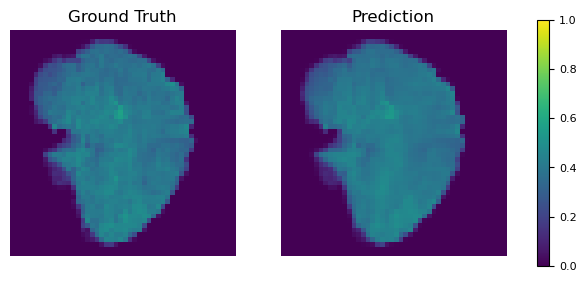

torch.Size([2, 1, 48, 48, 48, 2])
torch.Size([2, 1, 48, 48, 48, 2])
tensor(0.5389, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5630, device='cuda:0')
tensor(0., device='cuda:0')
tensor(37.0367, device='cuda:0')


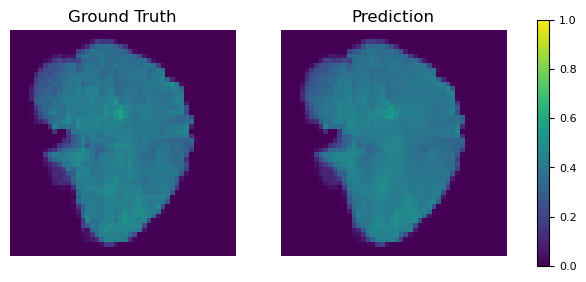

torch.Size([2, 1, 48, 48, 48, 2])
torch.Size([2, 1, 48, 48, 48, 2])
tensor(0.5338, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5598, device='cuda:0')
tensor(0., device='cuda:0')
tensor(37.2473, device='cuda:0')


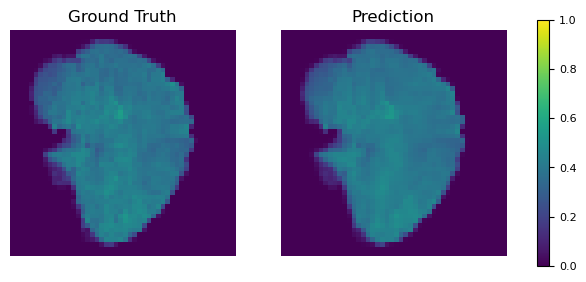

torch.Size([2, 1, 48, 48, 48, 2])
torch.Size([2, 1, 48, 48, 48, 2])
tensor(0.5336, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5612, device='cuda:0')
tensor(0., device='cuda:0')
tensor(37.0233, device='cuda:0')


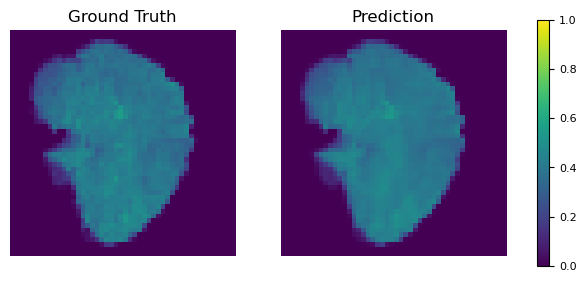

torch.Size([2, 1, 48, 48, 48, 2])
torch.Size([2, 1, 48, 48, 48, 2])
tensor(0.5377, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5614, device='cuda:0')
tensor(0., device='cuda:0')
tensor(37.1104, device='cuda:0')


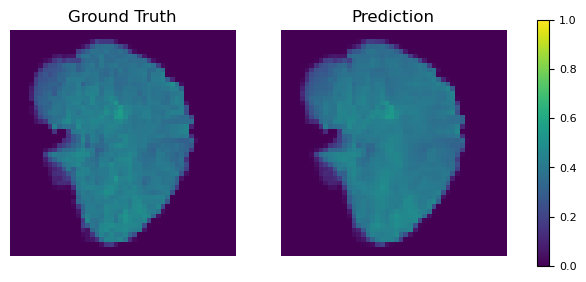

torch.Size([2, 1, 48, 48, 48, 2])
torch.Size([2, 1, 48, 48, 48, 2])
tensor(0.5393, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5769, device='cuda:0')
tensor(0., device='cuda:0')
tensor(37.1060, device='cuda:0')


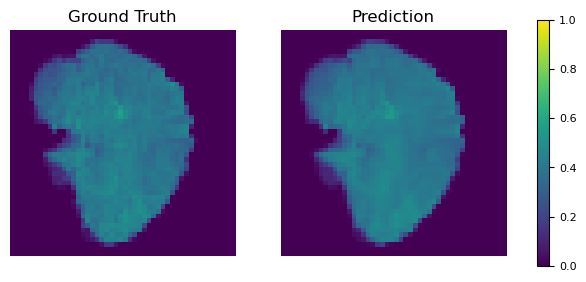

torch.Size([2, 1, 48, 48, 48, 2])
torch.Size([2, 1, 48, 48, 48, 2])
tensor(0.6962, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.6970, device='cuda:0')
tensor(0., device='cuda:0')
tensor(36.5342, device='cuda:0')


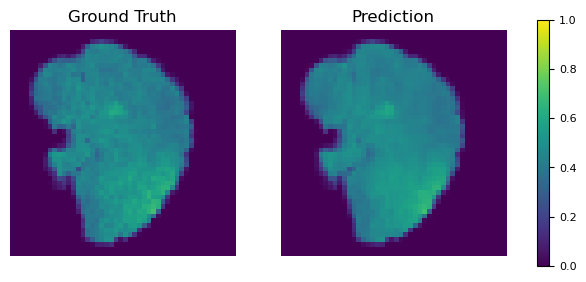

torch.Size([2, 1, 48, 48, 48, 2])
torch.Size([2, 1, 48, 48, 48, 2])
tensor(0.6907, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.6909, device='cuda:0')
tensor(0., device='cuda:0')
tensor(36.4296, device='cuda:0')


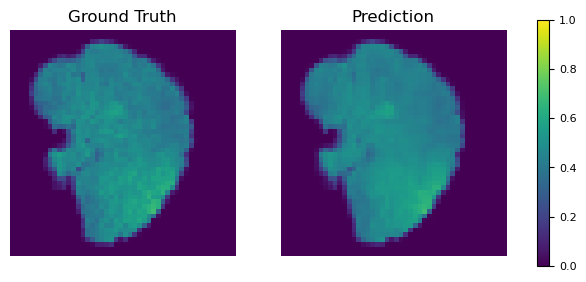

torch.Size([2, 1, 48, 48, 48, 2])
torch.Size([2, 1, 48, 48, 48, 2])
tensor(0.6946, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.6942, device='cuda:0')
tensor(0., device='cuda:0')
tensor(36.7240, device='cuda:0')


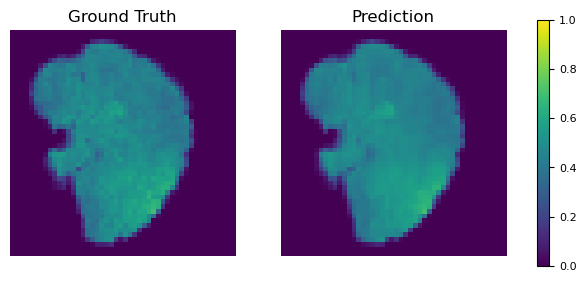

torch.Size([2, 1, 48, 48, 48, 2])
torch.Size([2, 1, 48, 48, 48, 2])
tensor(0.6978, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.7001, device='cuda:0')
tensor(0., device='cuda:0')
tensor(36.4144, device='cuda:0')


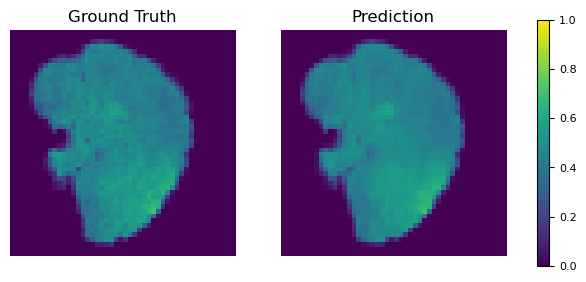

In [7]:
visualize_results(model, test_loader, device, n_samples=10, out_dir='./eval_vis', figsize=(12, 6), res_factor = 1, lainr=True, sr = False)

Available scalar tags: ['lr', 'train/loss', 'train/psnr', 'test/loss', 'test/psnr']


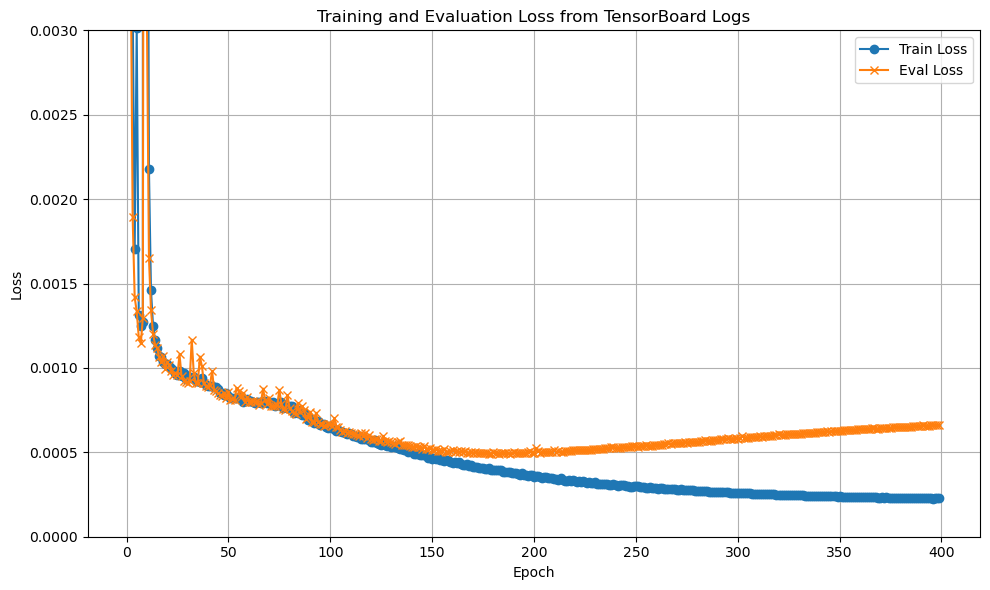

In [25]:
import os
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt

def arrays_from_tensorboard(run_name):
    # Path to your TensorBoard run directory (e.g., './runs/Jul13_13-21-57_my_run')
    #run_name = 'fmri_hcp_small_patch_resizelr_min20_hfmv_resume'
    log_dir = f'./save/{run_name}/tensorboard'
    
    # Load the TensorBoard event file
    ea = event_accumulator.EventAccumulator(log_dir,
        size_guidance={  # Load scalars, histograms, etc.
            event_accumulator.SCALARS: 0,
        })
    ea.Reload()
    
    # List available scalar tags
    print("Available scalar tags:", ea.Tags()['scalars'])
    
    # Change these if your tags are named differently
    train_loss_tag = 'train/loss'
    eval_loss_tag = 'test/loss'
    train_psnr_tag = 'train/psnr'
    eval_psnr_tag = 'test/psnr'
    
    # Extract data for each tag
    train_events = ea.Scalars(train_loss_tag)
    eval_events = ea.Scalars(eval_loss_tag)
    
    train_events_psnr = ea.Scalars(train_psnr_tag)
    eval_events_psnr = ea.Scalars(eval_psnr_tag)
    
    start_point = 0
    end_point = -1
    # Extract steps and values
    train_steps = [e.step for e in train_events][start_point:end_point]
    train_values = [e.value for e in train_events][start_point:end_point]
    
    eval_steps = [e.step for e in eval_events][start_point:end_point]
    eval_values = [e.value for e in eval_events][start_point:end_point]
    

    return [(train_steps, train_values),(eval_steps, eval_values)]

'''pre = arrays_from_tensorboard('fmri_hcp_small_patch_resizelr_min20_hfmv')
resume = arrays_from_tensorboard('fmri_hcp_small_patch_resizelr_min20_hfmv_resume')

train_steps = pre[0][0] + resume[0][0]
train_values = pre[0][1] + resume[0][1]
eval_steps = pre[1][0] + resume[1][0]
eval_values = pre[1][1] + resume[1][1]'''

pre = arrays_from_tensorboard('fmri_hcp_medium_patch_resizelr_min10_hfmv_lainr')

train_steps = pre[0][0] 
train_values = pre[0][1]
eval_steps = pre[1][0]
eval_values = pre[1][1]

plt.figure(figsize=(10, 6))
plt.plot(train_steps, train_values, label='Train Loss', marker='o')
plt.plot(eval_steps, eval_values, label='Eval Loss', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 0.003)
plt.title('Training and Evaluation Loss from TensorBoard Logs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
